In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
enable_eager_execution()

import os
import sys
sys.path.insert(0, '/mnt/home/raheppt1/projects/age_prediction')
import numpy as np
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

# tensorflow-gpu 2.1.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.optimizers import *
import tensorflow_probability as tfp

from dataset import AgeData
from misc import utils

In [2]:
# todo move models to file
def build_simple_model(input_shape=(124, 124, 124, 1),
                       lambda_l2=0.00005):
    model = Sequential()
    model.add(Conv3D(8, kernel_size=(3, 3, 3),  padding='same', input_shape=input_shape))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(Dense(1, activation='linear', bias_initializer=tf.constant_initializer(50.0)))
    return model

In [3]:
def build_aleatoric_model(input_shape=(124, 124, 124, 1),
                         lambda_l2=0.00005):
    model = Sequential()
    model.add(Conv3D(8, kernel_size=(3, 3, 3),  padding='same', input_shape=input_shape))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(Dense(1 + 1, activation='linear'))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                           scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))))
    return model


In [4]:
def build_quantile_model(input_shape=(124, 124, 124, 1),
                       lambda_l2=0.00005):
    model = Sequential()
    model.add(Conv3D(8, kernel_size=(3, 3, 3),  padding='same', input_shape=input_shape))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2)))
    model.add(Dense(3, activation='linear', bias_initializer=tf.constant_initializer(50.0)))
    return model

In [5]:
def build_epistemic_model(input_shape=(124, 124, 124, 1)):
    model = Sequential()
    model.add(tfp.layers.Convolution3DReparameterization(8,
                                                         kernel_size=(3, 3, 3),  padding='same',
                                                         input_shape=input_shape))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(16, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(tfp.layers.DenseReparameterization(1024, activation='relu'))
    model.add(tfp.layers.DenseReparameterization(512, activation='relu'))
    model.add(tfp.layers.DenseReparameterization(1, activation='linear'))
    model.add(tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1)))
    return model

In [6]:
def build_combined_model(input_shape=(124, 124, 124, 1)):
    model = Sequential()
    model.add(tfp.layers.Convolution3DReparameterization(8,
                                                         kernel_size=(3, 3, 3),  padding='same',
                                                         input_shape=input_shape))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(16, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(32, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(64, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(tfp.layers.Convolution3DReparameterization(128, kernel_size=(3, 3, 3), padding='same'))
    model.add(ReLU())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(tfp.layers.DenseReparameterization(1024, activation='relu'))
    model.add(tfp.layers.DenseReparameterization(512, activation='relu'))
    model.add(tfp.layers.DenseReparameterization(1 + 1, activation='linear'))
    model.add(tfp.layers.DistributionLambda(
              lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                                 scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))))
    return model

In [7]:
image_size = [100, 120, 100]
image_spacing = [1.5, 1.5, 1.5]
lambda_l2 = 0.00005
batch_size = 16

# TODO save current models to file!!!!!!!!!!!!!!!!!!!!
# replace with models from defitinion file
# Update all trainings (MAE, MSE metrics, loss function, KL_loss)

In [8]:
# Load training and test data.
age_data = AgeData(image_size,
                   image_spacing,
                   shuffle_training_images=True,
                   save_debug_images=False)
dataset_train = age_data.dataset_train()
train_samples = dataset_train.num_entries()
dataset_val = age_data.dataset_val()
val_samples = dataset_val.num_entries()
print(train_samples, val_samples)

# Define training and validation datasets from generators.
def train_gen():
    data = dataset_train
    i = 0
    while i < data.num_entries():
        sample = data.get_next()
        # DHWC tensor format
        image = sample['generators']['image'].transpose([1, 2, 3, 0])
        image = image.astype('float32')
        age = sample['generators']['age']
        yield image, age
        i += 1

def val_gen():
    data = dataset_val
    i = 0
    while i < data.num_entries():
        sample = data.get_next()
        image = sample['generators']['image'].transpose([1, 2, 3, 0])
        image = image.astype('float32')
        age = sample['generators']['age']
        yield image, age
        i += 1

ds_train = tf.data.Dataset.from_generator(train_gen,
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=(tf.TensorShape((None, None, None, None)),
                                                         tf.TensorShape((1, ))))
ds_train = ds_train.batch(batch_size=batch_size)

ds_val = tf.data.Dataset.from_generator(val_gen,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=(tf.TensorShape((None, None, None, None)),
                                                       tf.TensorShape((1, ))))
ds_val = ds_val.batch(batch_size=batch_size)

loaded 410 ids
loaded 103 ids
410 103


In [10]:
simple_model = build_simple_model(image_size + [1], lambda_l2)
aleatoric_model = build_aleatoric_model(image_size + [1], lambda_l2)
quantile_model = build_quantile_model(image_size + [1], lambda_l2)
epistemic_model = build_epistemic_model(image_size + [1])
combined_model = build_combined_model(image_size + [1])

checkpoint_path = Path('/mnt/share/raheppt1/tf_models/age/keras/aleatoric_01/')
latest = tf.train.latest_checkpoint(checkpoint_path)
aleatoric_model.load_weights(str(latest))

checkpoint_path = Path('/mnt/share/raheppt1/tf_models/age/keras/quantile_02/')
latest = tf.train.latest_checkpoint(checkpoint_path)
quantile_model.load_weights(str(latest))

#checkpoint_path = Path('/mnt/share/raheppt1/tf_models/age/keras/epistemic_02/')
#latest = tf.train.latest_checkpoint(checkpoint_path)
#epistemic_model.load_weights(str(latest))

#checkpoint_path = Path('/mnt/share/raheppt1/tf_models/age/keras/combined_01/')
#latest = tf.train.latest_checkpoint(checkpoint_path)
def mean_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true[:, 0], y_pred[:, 1])

def mean_mse(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:, 0], y_pred[:, 1])
#combined_model.load_weights(str(latest))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f76a44df8d0> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f76a44cbdd0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f76a44e2610> and <tensorflow.python.keras.layers.core.Dense object at 0x7f76a44df8d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f76a4495c50> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f76a44e29d0>).


In [24]:
def mean_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true[:, 0], y_pred.mean()[:, 0])

def mean_mse(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:, 0], y_pred.mean()[:, 0])

preds_list = []
test_list = []
for test_images, test_labels in ds_val:
    predictions = aleatoric_model(test_images, training=False)
    preds_list.append(tf.concat([predictions.mean(), predictions.stddev()], axis=1))
    test_list.append(test_labels)
    print(mean_mae(test_labels, predictions))
    print(mean_mse(test_labels, predictions))
all_tests = tf.concat(test_list, axis=0)
all_preds = tf.concat(preds_list, axis=0)


tf.Tensor(6.8375654, shape=(), dtype=float32)
tf.Tensor(84.53161, shape=(), dtype=float32)
tf.Tensor(5.1710305, shape=(), dtype=float32)
tf.Tensor(36.368275, shape=(), dtype=float32)
tf.Tensor(7.3925138, shape=(), dtype=float32)
tf.Tensor(75.67369, shape=(), dtype=float32)
tf.Tensor(5.496934, shape=(), dtype=float32)
tf.Tensor(46.657288, shape=(), dtype=float32)
tf.Tensor(5.001235, shape=(), dtype=float32)
tf.Tensor(42.789032, shape=(), dtype=float32)
tf.Tensor(7.002363, shape=(), dtype=float32)
tf.Tensor(64.11942, shape=(), dtype=float32)
tf.Tensor(7.5936427, shape=(), dtype=float32)
tf.Tensor(90.54217, shape=(), dtype=float32)


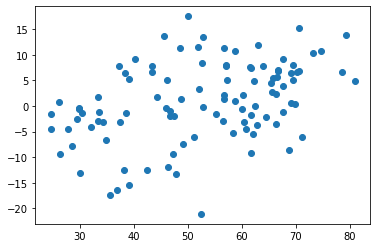

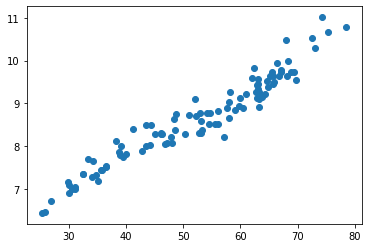

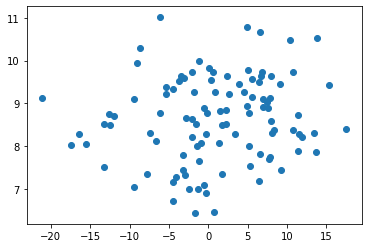

In [26]:
plt.scatter((all_tests[:, 0]+all_preds[:, 0])/2, all_tests[:, 0] - all_preds[:, 0])
plt.show()
plt.scatter(all_preds[:, 0], all_preds[:, 1])
plt.show()

plt.scatter(all_tests[:, 0]-all_preds[:, 0], all_preds[:, 1])
plt.show()

tf.Tensor(7.7858205, shape=(), dtype=float32)
tf.Tensor(88.54587, shape=(), dtype=float32)
tf.Tensor(3.9006574, shape=(), dtype=float32)
tf.Tensor(23.547226, shape=(), dtype=float32)
tf.Tensor(5.6472583, shape=(), dtype=float32)
tf.Tensor(42.70907, shape=(), dtype=float32)
tf.Tensor(6.058401, shape=(), dtype=float32)
tf.Tensor(61.115677, shape=(), dtype=float32)
tf.Tensor(5.0250216, shape=(), dtype=float32)
tf.Tensor(39.13021, shape=(), dtype=float32)
tf.Tensor(3.8418744, shape=(), dtype=float32)
tf.Tensor(25.941713, shape=(), dtype=float32)
tf.Tensor(7.688152, shape=(), dtype=float32)
tf.Tensor(91.45399, shape=(), dtype=float32)


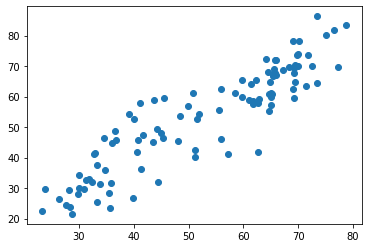

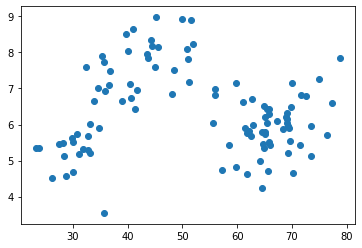

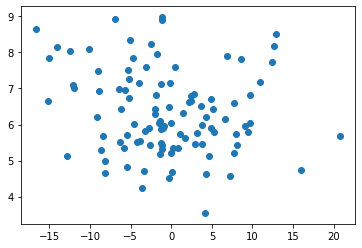

In [11]:
def mean_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true[:, 0], y_pred[:, 1])

def mean_mse(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:, 0], y_pred[:, 1])

pred_list = []
test_list = []
for test_images, test_labels in ds_val:
    predictions = quantile_model(test_images, training=False)
    pred_list.append(predictions)
    test_list.append(test_labels)
    print(mean_mae(test_labels, predictions))
    print(mean_mse(test_labels, predictions))
all_tests = tf.concat(test_list, axis=0)
all_preds = tf.concat(pred_list, axis=0)


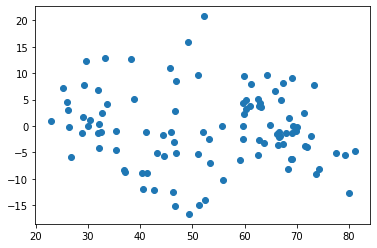

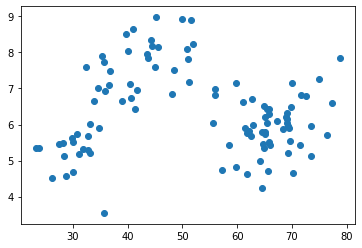

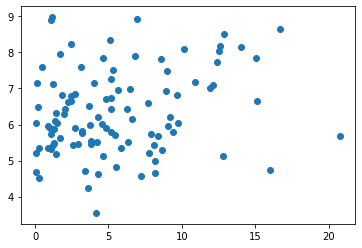

0.22423497649325044


In [23]:
plt.scatter((all_preds[:, 1]+all_tests[:, 0])/2
            , all_preds[:, 1]-all_tests[:, 0])
plt.show()
plt.scatter(all_preds[:, 1], all_preds[:, 2] - all_preds[:, 0])
plt.show()
plt.scatter(tf.abs(all_preds[:, 1] - all_tests[:, 0]), all_preds[:, 2] - all_preds[:, 0])
plt.show()

from scipy.stats import pearsonr
pred_error = all_preds[:, 2] - all_preds[:, 0]
pred_error = pred_error.numpy()
corr, _ = pearsonr(tf.abs(all_preds[:, 1] - all_tests[:, 0]).numpy(), pred_error )
print(corr)

In [21]:

for test_images, test_labels in ds_val:
    predictions = epistemic_model(test_images, training=False)
    print(test_labels)
    print(predictions.mean())
    break

tf.Tensor(
[[67.73991 ]
 [73.56332 ]
 [48.678986]
 [56.919918]
 [52.689938]
 [64.10404 ]
 [54.19302 ]
 [41.09514 ]
 [60.919918]
 [67.16222 ]
 [58.792606]
 [66.9076  ]
 [64.64613 ]
 [46.431213]
 [62.455853]
 [53.749485]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[108.92662 ]
 [ 50.178936]
 [ 86.0356  ]
 [180.99731 ]
 [125.18924 ]
 [ 17.438063]
 [114.72191 ]
 [136.00891 ]
 [ 55.508846]
 [101.5226  ]
 [136.67915 ]
 [ 99.34773 ]
 [ 46.07519 ]
 [141.38326 ]
 [ 75.6028  ]
 [ 53.91824 ]], shape=(16, 1), dtype=float32)


In [54]:
for test_images, test_labels in ds_val:
    predictions = combined_model(test_images, training=False)
    print(test_labels)
    print(predictions.stddev())
    break

tf.Tensor(
[[21.566051]
 [74.02601 ]
 [23.34839 ]
 [37.73306 ]
 [31.854895]
 [41.752224]
 [28.158794]
 [46.168377]
 [68.602325]
 [52.533882]
 [49.40452 ]
 [41.82067 ]
 [26.877481]
 [29.730322]
 [41.511295]
 [45.774128]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[52267.24 ]
 [64549.027]
 [65051.613]
 [57610.87 ]
 [65794.445]
 [59610.926]
 [61448.77 ]
 [64126.062]
 [60928.074]
 [61557.008]
 [59820.543]
 [62356.05 ]
 [60548.22 ]
 [58984.168]
 [54842.746]
 [57183.418]], shape=(16, 1), dtype=float32)


In [ ]:
# mae losses
# results aleatoric quantile
# test bayesian with mse